# Classification of the defaulted vs not-defaulted clients and selection of the most meaningful features in the dataset.

In this notebook a variety of concepts were applied to the dataset. First of all we are dealing with imbalanced dataset, 28% of records are for the clients who defaulted in October 2005. 

** We have used imblearn module to produce oversampled training set with equal number of records for each class by bootstrapping. The model was evaluated on the test set without oversampling. **

** For the case where we do not use oversampling but adjusting the weights during training refer to machine_learning.ipynb in the capstone1/ folder. **

The dataset contains records of bill amounts, payment amounts, repayment statuses for 6 months, April, 2005 to September, 2005. The 'default' column shows whether a client defaulted or not in October, 2005. After applying RandomForest feature selection it became clear that these data would play important role for classification algorithms, in particular repayment status in September, 2005 is the most important factor whether a client defaults or not in the following month. These observations are also confirmed by fitting the training data with Logit function of statsmodels.api, which shows that the bill amount, payment amount and repayment status for September are indeed statistically significant features, with corresponding p-values = 0.000 This observation is also intuitive, showing that the financial health of a client one month before default or not-default is very important factor.

Based on the available financial data additional features were introduced in the dataset. The first set of features is credit utilization for each month, calculated as bill amount / credit amount. The second set of features is cash flow for each month, calculated as payment amount - bill amount. The cashflow values are negative when a client pays less than the bill amount for a given month, zero when the bill is fully repaid, and positive when a client pays more than the bill amount.

The following pre-processing steps were taken before the classification models were applied: The outliers of the numerical columns defined as lower_bound = quartile_1 - (float(iqr) * 1.5), upper_bound = quartile_3 + (float(iqr) * 1.5) were replaced with median values. For this dataset there were no missing categorical or numerical values, but as part of pre-processing workflow the functions imputing missing categorical and numerical features were included in the code. To prepare the dataset for machine learning models, the categorical features were converted to dummy variables, the numeric columns were standardized using StandardScaler, which was first used to fit and transform training data and then transform test data. 

The dataset was split into training and test sets, validation set was introduced in the training set as a part of stratified K fold cross validation.

Three classification models were applied: logistic regression, random forest classifier and RBF kernel support vector machine (SVM). For all models the hyperparameters were tuned, first using validation curve and then using grid search cross validation based on AUC scoring. For logistic regression regularization strength C was tuned, for random forest max depth of trees and number of estimators were tuned, for SVM regularization strength C and kernel parameter gamma were tuned. Performance of the optimized models on training data was assessed using stratified cross validation and AUC score as a scoring metric. Performance on test data was assessed using AUC score, as well as precision and recall metrics.

Classification accuracy results are the following:

| **Logistic reg** |precision | recall  | f1-score |
|------------------|----------|---------|----------|
|not defaulted     |   0.87   |  0.70   |  0.78    |
|   defaulted      |   0.37   |  0.63   |  0.47    |
|   accuracy       |          |         |  0.69    |


| **Random forest** |precision | recall  | f1-score |
|-------------------|----------|---------|----------|
|not defaulted      |   0.88   |  0.76   |  0.82    |
|   defaulted       |   0.43   |  0.64   |  0.52    |
|   accuracy        |          |         |  0.73    |


| **RBF kernel SVM** |precision | recall  | f1-score |
|--------------------|----------|---------|----------|
|not defaulted       |   0.88   |  0.77   |  0.82    |
|   defaulted        |   0.44   |  0.63   |  0.52    |
|   accuracy         |          |         |  0.74    |

| **Ensemble**       |precision | recall  | f1-score |
|--------------------|----------|---------|----------|
|not defaulted       |   0.88   |  0.78   |  0.83    |
|   defaulted        |   0.44   |  0.63   |  0.52    |
|   accuracy         |          |         |  0.74    |

|                 |logistic regression | Random forest | RBF kernel SVM | Ensemble       |
|-----------------|--------------------|---------------|----------------|----------------|
|AUC on test data |        0.73        |     0.77      |     0.75       |     0.77       |


** Some parts of the code below were taken from 'Python Machine Learning' by Sebastian Raschka. **

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
%matplotlib inline


df = pd.read_csv("defaults.csv", header = 1, index_col = 'ID')
df.columns = [x.lower() for x in list(df.columns)]
df.columns = ['credit_amount', 'sex', 'education', 'marital_status', 'age', 'pay_sept', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr',
       'default']

for column in ['credit_amount', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']:
    df[column] = df[column]/1000
    
gender_remapping = {1: 'male', 2: 'female'}
df.sex = df.sex.map(gender_remapping)

df.education = df.education.astype(str)
education_remapping = {'1': 'grad_school', '2': 'bachelors', '3': 'high_school', '4': 'other', 
                       '5': 'other', '6': 'other', '0': 'other'}
df.education = df.education.map(education_remapping)

df.marital_status = df.marital_status.astype(str)
marital_status_remapping = {'1': 'married', '2': 'single', '3': 'divorced', '0': 'other'}
df.marital_status = df.marital_status.map(marital_status_remapping)

# Original dataset

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
credit_amount     30000 non-null float64
sex               30000 non-null object
education         30000 non-null object
marital_status    30000 non-null object
age               30000 non-null int64
pay_sept          30000 non-null int64
pay_aug           30000 non-null int64
pay_jul           30000 non-null int64
pay_jun           30000 non-null int64
pay_may           30000 non-null int64
pay_apr           30000 non-null int64
bill_amt_sept     30000 non-null float64
bill_amt_aug      30000 non-null float64
bill_amt_jul      30000 non-null float64
bill_amt_jun      30000 non-null float64
bill_amt_may      30000 non-null float64
bill_amt_apr      30000 non-null float64
pay_amt_sept      30000 non-null float64
pay_amt_aug       30000 non-null float64
pay_amt_jul       30000 non-null float64
pay_amt_jun       30000 non-null float64
pay_amt_may       30000 non-null float64
pay_am

In [59]:
df.columns

Index(['credit_amount', 'sex', 'education', 'marital_status', 'age',
       'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr', 'default'],
      dtype='object')

# Feature engineering.

** Credit utilization columns for each month. **

In [60]:
for column in ['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
               'bill_amt_may', 'bill_amt_apr']:
    df['credit_util_' + column.split('_')[2]] = df.loc[:, column] / df.loc[:, 'credit_amount']

In [61]:
df.loc[:5, ['credit_amount', 'bill_amt_sept', 'credit_util_sept']]

,credit_amount,bill_amt_sept,credit_util_sept
ID,,,
1,20.0,3.913,0.195650
2,120.0,2.682,0.022350
3,90.0,29.239,0.324878
4,50.0,46.990,0.939800
5,50.0,8.617,0.172340


** Cashflow for each month. **

In [62]:
bills = ['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr']
payms = ['pay_amt_sept', 'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']

for bill, paym in zip(bills, payms):
    df['cash_flow_' + bill.split('_')[2]] = df.loc[:, paym] - df.loc[:, bill] 

In [63]:
df.head()

,credit_amount,sex,education,marital_status,age,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,...,credit_util_jul,credit_util_jun,credit_util_may,credit_util_apr,cash_flow_sept,cash_flow_aug,cash_flow_jul,cash_flow_jun,cash_flow_may,cash_flow_apr
ID,,,,,,,,,,,,,,,,,,,,,
1,20.0,female,bachelors,married,24,2,2,-1,-1,-2,...,0.034450,0.000000,0.000000,0.000000,-3.913,-2.413,-0.689,0.000,0.000,0.000
2,120.0,female,bachelors,single,26,-1,2,0,0,0,...,0.022350,0.027267,0.028792,0.027175,-2.682,-0.725,-1.682,-2.272,-3.455,-1.261
3,90.0,female,bachelors,single,34,0,0,0,0,0,...,0.150656,0.159233,0.166089,0.172767,-27.721,-12.527,-12.559,-13.331,-13.948,-10.549
4,50.0,female,bachelors,married,37,0,0,0,0,0,...,0.985820,0.566280,0.579180,0.590940,-44.990,-46.214,-48.091,-27.214,-27.890,-28.547
5,50.0,male,bachelors,married,57,-1,0,-1,0,0,...,0.716700,0.418800,0.382920,0.382620,-6.617,31.011,-25.835,-11.940,-18.457,-18.452


# Train - test split.

In [64]:
X_columns = df.drop(['default'], axis = 1).columns
X = df.drop(['default'], axis = 1).values
y = df[['default']].values.ravel()

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, stratify = y, test_size=0.3, random_state=1)

In [65]:
from collections import Counter
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 16355), (1, 4645)]
[(0, 7009), (1, 1991)]


# Applying random oversampling on the train data.

In [66]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [67]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 16355), (1, 16355)]
[(0, 7009), (1, 1991)]


In [68]:
X_train = pd.DataFrame(X_train, columns = X_columns)
X_test = pd.DataFrame(X_test, columns = X_columns)

In [69]:
X_train['credit_amount'] = X_train['credit_amount'].astype('int64')
X_train.loc[:, 'age':'pay_apr'] = X_train.loc[:, 'age':'pay_apr'].astype('int64')
X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'] = X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')
X_train.loc[:, 'credit_util_sept':'cash_flow_apr'] = X_train.loc[:, 'credit_util_sept':'cash_flow_apr'].astype('float64')

X_test['credit_amount'] = X_test['credit_amount'].astype('int64')
X_test.loc[:, 'age':'pay_apr'] = X_test.loc[:, 'age':'pay_apr'].astype('int64')
X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'] = X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')
X_test.loc[:, 'credit_util_sept':'cash_flow_apr'] = X_test.loc[:, 'credit_util_sept':'cash_flow_apr'].astype('float64')

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32710 entries, 0 to 32709
Data columns (total 35 columns):
credit_amount       32710 non-null int64
sex                 32710 non-null object
education           32710 non-null object
marital_status      32710 non-null object
age                 32710 non-null int64
pay_sept            32710 non-null int64
pay_aug             32710 non-null int64
pay_jul             32710 non-null int64
pay_jun             32710 non-null int64
pay_may             32710 non-null int64
pay_apr             32710 non-null int64
bill_amt_sept       32710 non-null float64
bill_amt_aug        32710 non-null float64
bill_amt_jul        32710 non-null float64
bill_amt_jun        32710 non-null float64
bill_amt_may        32710 non-null float64
bill_amt_apr        32710 non-null float64
pay_amt_sept        32710 non-null float64
pay_amt_aug         32710 non-null float64
pay_amt_jul         32710 non-null float64
pay_amt_jun         32710 non-null float64
pay_amt

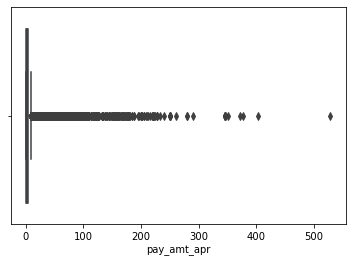

In [71]:
_ = sns.boxplot(X_train['pay_amt_apr'])  
plt.show()

In [72]:
float_columns = X_train.select_dtypes(include=['float64']).columns
int_columns=X_train.select_dtypes(include=['int64']).columns

numeric_columns=float_columns.union(int_columns)

categorical_columns = X_train.select_dtypes(include=['object']).columns

In [73]:
categorical_columns

Index(['sex', 'education', 'marital_status'], dtype='object')

In [74]:
numeric_columns

Index(['age', 'bill_amt_apr', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_sept', 'cash_flow_apr', 'cash_flow_aug',
       'cash_flow_jul', 'cash_flow_jun', 'cash_flow_may', 'cash_flow_sept',
       'credit_amount', 'credit_util_apr', 'credit_util_aug',
       'credit_util_jul', 'credit_util_jun', 'credit_util_may',
       'credit_util_sept', 'pay_amt_apr', 'pay_amt_aug', 'pay_amt_jul',
       'pay_amt_jun', 'pay_amt_may', 'pay_amt_sept', 'pay_apr', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_sept'],
      dtype='object')

# Replacing outliers, imputing missing numerical and categorical values.

In [75]:
def outlier_replace(data,train,column):
    quartile_1, quartile_3 = np.percentile(train[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (float(iqr) * 1.5)
    upper_bound = quartile_3 + (float(iqr) * 1.5)
    data.loc[(data[column]<lower_bound) | (data[column] > upper_bound),[column]] = train[column].median()
    return data[column]

In [76]:
def imputation_missing_numerical(data,train,column):
    data[column] = data[column].fillna(train[column].median())
    return data[column]

In [77]:
def imputation_missing_categorical(data,column):
    data[column] = data[column].fillna('other')
    return data[column]   

In [78]:
for numeric in numeric_columns:
    X_train[numeric] = outlier_replace(X_train,X_train,numeric)
    #X_train[numeric] = imputation_missing_numerical(train_x,train_x,numeric)
    
    X_test[numeric] = outlier_replace(X_test,X_train,numeric)
    #X_test[numeric] = imputation_missing_numerical(X_test,X_train,numeric)   
    
#for categorical in categorical_columns:
#    X_train[categorical] = imputation_missing_categorical(X_train,categorical)
#    X_test[categorical] = imputation_missing_categorical(X_test,categorical)   

In [79]:
def dummies(data,col):
    y = pd.get_dummies(data[col],prefix=col)
    data.drop([col],axis=1,inplace=True)
    return y   

In [80]:
X_train_dummies  = pd.concat([dummies(X_train,col) for col in categorical_columns], axis=1)
X_test_dummies  = pd.concat([dummies(X_test,col) for col in categorical_columns], axis=1) 

In [81]:
# Get missing columns in the training vs test set
missing_cols = set(X_train_dummies.columns) - set(X_test_dummies.columns )
print(missing_cols)

# Add a missing column in the test set with default values equal to 0
for col in missing_cols:
    X_test_dummies[col] = 0

X_test_dummies=X_test_dummies[X_train_dummies.columns]

set()


In [82]:
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [83]:
X_train = pd.concat([X_train[numeric_columns],X_train_dummies],axis=1)
X_test = pd.concat([X_test[numeric_columns],X_test_dummies],axis=1)

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32710 entries, 0 to 32709
Data columns (total 42 columns):
age                        32710 non-null float64
bill_amt_apr               32710 non-null float64
bill_amt_aug               32710 non-null float64
bill_amt_jul               32710 non-null float64
bill_amt_jun               32710 non-null float64
bill_amt_may               32710 non-null float64
bill_amt_sept              32710 non-null float64
cash_flow_apr              32710 non-null float64
cash_flow_aug              32710 non-null float64
cash_flow_jul              32710 non-null float64
cash_flow_jun              32710 non-null float64
cash_flow_may              32710 non-null float64
cash_flow_sept             32710 non-null float64
credit_amount              32710 non-null float64
credit_util_apr            32710 non-null float64
credit_util_aug            32710 non-null float64
credit_util_jul            32710 non-null float64
credit_util_jun            32710 non-null

In [85]:
X_train.shape, X_test.shape

((32710, 42), (9000, 42))

# Learning curve and correspoding plotting function

** AUC scorer function. **

In [86]:
from sklearn.metrics import make_scorer

scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba = True)

In [87]:
def learning_curve_output(X_train, y_train, clf):
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf, 
                    X=X_train, 
                    y=y_train,
                    train_sizes=np.linspace(0.1, 1.0, 5),
                    cv=5,
                    scoring = scorer,
                    n_jobs=-1,
                    shuffle=True)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_sizes, train_mean, train_std, test_mean, test_std

In [88]:
def learning_curve_plt(train_sizes, train_mean, train_std, test_mean, test_std, clf_name):
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(train_sizes, train_mean, 
                 color='blue', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(train_sizes, 
                         train_mean + train_std,
                         train_mean - train_std, 
                         alpha=0.15, color='blue')

    _ = plt.plot(train_sizes, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(train_sizes, 
                         test_mean + test_std,
                         test_mean - test_std, 
                         alpha=0.15, color='green')

    _ = plt.title('Learning curve for ' + str(clf_name))
    _ = plt.xlabel('Number of training samples', fontsize=14)
    _ = plt.ylabel('AUC score', fontsize=14)
    _ = plt.legend(loc='lower right', fontsize=14)
    _ = plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# Validation curve and corresponding plotting function

In [89]:
def validation_curve_output(X_train, y_train, clf, param_range, param_name):

    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_train, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=5,
                    scoring = scorer,
                    n_jobs = -1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    return train_mean, train_std, test_mean, test_std

In [90]:
def validation_curve_plt(train_mean, train_std, test_mean, test_std, param_range, param_name, clf_name):
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(param_range, train_mean, 
                 color='blue', marker='o', 
                 markersize=5, label='training AUC')

    _ = plt.fill_between(param_range, train_mean + train_std,
                         train_mean - train_std, alpha=0.15,
                         color='blue')

    _ = plt.plot(param_range, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation AUC')

    _ = plt.fill_between(param_range, 
                         test_mean + test_std,
                         test_mean - test_std, 
                         alpha=0.15, color='green')

    _ = plt.xscale('log')
    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlabel('Parameter ' + str(param_name), fontsize = 14)
    _ = plt.ylabel('AUC score', fontsize = 14)
    _ = plt.title('Validation curve for ' + str(clf_name) + ':' + str(param_name), fontsize = 14)
    _ = plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    _ = plt.tight_layout()
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# ROC curve plotting function

In [91]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_plt(y_pred_train, y_pred_test, classifier):

    fpr_train, tpr_train, thresholds_train = roc_curve(y_true=y_train, y_score=y_pred_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_true=y_test, y_score=y_pred_test)

    roc_auc_train = auc(x=fpr_train, y=tpr_train)
    roc_auc_test = auc(x=fpr_test, y=tpr_test)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(fpr_train, tpr_train, color='black', linestyle='-', 
                 label='%s (auc = %0.3f)' % (classifier + ' train', roc_auc_train))
    _ = plt.plot(fpr_test, tpr_test, color='red', linestyle='-', 
                 label='%s (auc = %0.3f)' % (classifier + ' test', roc_auc_test))
    _ = plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('False Positive Rate', fontsize = 14)
    _ = plt.ylabel('True Positive Rate', fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    _ = plt.tight_layout()
    _ = plt.title('ROC curve', fontsize = 14)
    
    return plt.show()

# Precision - recall plotting function.

In [92]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def precision_recall_curve_plt(y_pred_train, y_pred_test, classifier):

    average_precision = average_precision_score(y_true = y_test, y_score = y_pred_test)

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_true=y_train, 
                                                                             probas_pred=y_pred_train)
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_true=y_test, 
                                                                          probas_pred=y_pred_test)

    _ = plt.figure(figsize=(7,5))
    _ = plt.plot(recall_train, precision_train, color='black', linestyle='-', 
                 label='%s' % (classifier + ' train'))
    _ = plt.plot(recall_test, precision_test, color='red', linestyle='-', 
                 label='%s' % (classifier + ' test'))
    _ = plt.legend(loc='lower right', fontsize = 14)
    _ = plt.xlim([0., 1.])
    _ = plt.ylim([0., 1.])
    _ = plt.xlabel('Recall', fontsize = 14)
    _ = plt.ylabel('Precision', fontsize = 14)
    _ = plt.tight_layout()
    _ = plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision), fontsize = 14)
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
    
    return plt.show()

# Logistic regression

In [93]:
clf = LogisticRegression(solver = 'lbfgs', penalty = 'l2', n_jobs = -1)

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Training accuracy (default logistic regression):', 
      accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test accuracy (default logistic regression):', 
      accuracy_score(y_true = y_test, y_pred = y_pred_test))

print('AUC score for the training data (default logistic regression):', 
      roc_auc_score(y_true = y_train, y_score = clf.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default logistic regression):', 
      roc_auc_score(y_true = y_test, y_score = clf.predict_proba(X_test)[:,1]))

Training accuracy (default logistic regression): 0.680800978294
Test accuracy (default logistic regression): 0.686777777778
AUC score for the training data (default logistic regression): 0.737987152787
AUC score for the test data (default logistic regression): 0.728244212668


# Validation curve (logistic regression)

In [94]:
clf_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_mean_lr, train_std_lr, test_mean_lr, test_std_lr = validation_curve_output(X_train.values, 
                                                                                 y_train, 
                                                                                 clf, 
                                                                                 clf_param_range, 
                                                                                 'C')

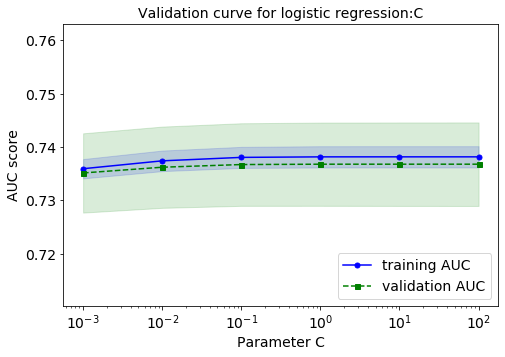

In [95]:
validation_curve_plt(train_mean_lr, 
                     train_std_lr, 
                     test_mean_lr, 
                     test_std_lr, 
                     clf_param_range, 
                     'C', 
                     'logistic regression')

# Hyperparameter tuning using grid search (logistic regression)

In [96]:
C_range = [1.0, 10.0, 100.0, 1000.0]

param_grid = [{'C': C_range}]

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs.best_score_))
print('Best parameters: ' + str(gs.best_params_))

Best AUC score on training data: 0.736769584504
Best parameters: {'C': 100.0}


In [97]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('AUC score on test data: %.3f' %roc_auc_score(y_true = y_test, y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score on test data: 0.728


# Stratified K-fold cross-validation (logistic regression).

In [98]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_clf.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_clf.predict_proba(X_train.values[test_fold])[:,1])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [13084 13084], Train AUC score: 0.726
Fold: 2, Class dist.: [13084 13084], Train AUC score: 0.736
Fold: 3, Class dist.: [13084 13084], Train AUC score: 0.743
Fold: 4, Class dist.: [13084 13084], Train AUC score: 0.732
Fold: 5, Class dist.: [13084 13084], Train AUC score: 0.744

 CV AUC score: 0.736 +/- 0.007


# Learning curve (logistic regression)

In [99]:
train_sizes_lr_lc, train_mean_lr_lc, train_std_lr_lc, test_mean_lr_lc, test_std_lr_lc = \
    learning_curve_output(X_train.values, 
                          y_train, 
                          best_clf)

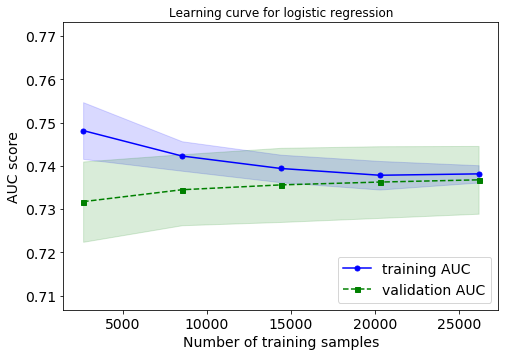

In [100]:
learning_curve_plt(train_sizes_lr_lc, 
                   train_mean_lr_lc, 
                   train_std_lr_lc, 
                   test_mean_lr_lc, 
                   test_std_lr_lc,
                  'logistic regression')

# Confusion matrix (logistic regression)

In [101]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[4908 2101]
 [ 731 1260]]


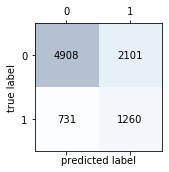

In [102]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

**We want to have 1 as a positive class in the confusion matric in the top left corner, therefore we need to swap labels in the confusion matrix.**

**1 - default**
**0 - no default**

In [103]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

[[1260  731]
 [2101 4908]]


In [104]:
print('Precisoin from the above matrix = ' + str(confmat[0][0]/(confmat[0][0] + confmat[1][0])))

Precisoin from the above matrix = 0.374888426064


# Classification report for test data (logistic regression).

In [105]:
print('AUC score for the test data:', roc_auc_score(y_true = y_test, y_score = best_clf.predict_proba(X_test)[:,1]))

AUC score for the test data: 0.728434754799


In [106]:
print(classification_report(y_test, y_pred, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.87      0.70      0.78      7009
    defaulted       0.37      0.63      0.47      1991

     accuracy                           0.69      9000
    macro avg       0.62      0.67      0.62      9000
 weighted avg       0.76      0.69      0.71      9000



# ROC and Precision - Recall curves (logistic regression).

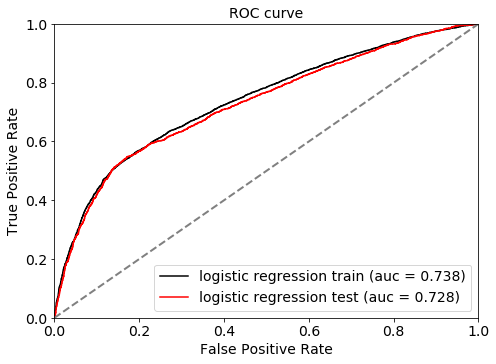

In [107]:
# assuming the label of the positive class is 1
y_pred_lr_train = best_clf.predict_proba(X_train)[:, 1]
y_pred_lr_test = best_clf.predict_proba(X_test)[:, 1]

ROC_plt(y_pred_lr_train, y_pred_lr_test, 'logistic regression')

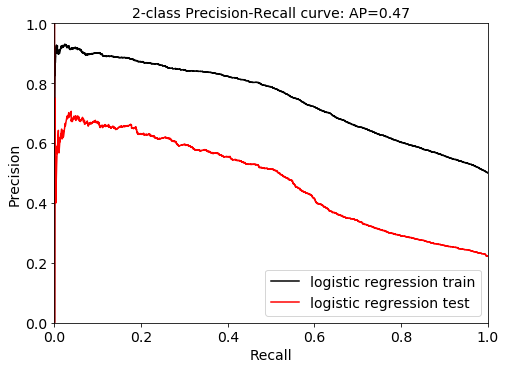

In [108]:
precision_recall_curve_plt(y_pred_lr_train, y_pred_lr_test, 'logistic regression')

# Random Forest classifier

In [109]:
rand_forest = RandomForestClassifier(n_jobs = -1)

# Fit the model on the trainng data.
rand_forest.fit(X_train, y_train)

print('Training accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_train), y_train))
print('Test accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_test), y_test))

print('AUC score for the training data (default random forest):', 
      roc_auc_score(y_true = y_train, y_score = rand_forest.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default random forest):', 
      roc_auc_score(y_true = y_test, y_score = rand_forest.predict_proba(X_test)[:,1]))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy (default random forest): 0.997584836441
Test accuracy (default random forest): 0.795555555556
AUC score for the training data (default random forest): 0.999924525029
AUC score for the test data (default random forest): 0.727636541638


# Validation curve (random forest)

In [110]:
max_depth = [4, 6, 10, 14, 18, 22, 26]

train_mean_rf_dep, train_std_rf_dep, test_mean_rf_dep, test_std_rf_dep = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            rand_forest, 
                            max_depth, 
                            'max_depth')

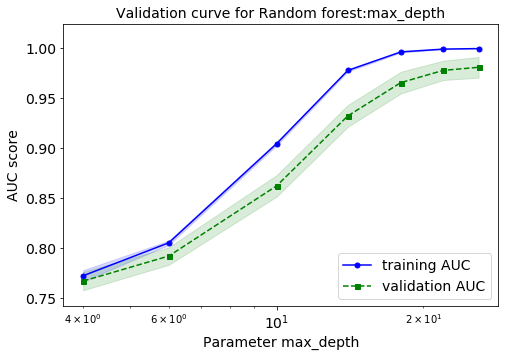

In [111]:
validation_curve_plt(train_mean_rf_dep, 
                     train_std_rf_dep, 
                     test_mean_rf_dep, 
                     test_std_rf_dep, 
                     max_depth, 
                     'max_depth', 
                     'Random forest')

In [112]:
n_estimators = [5, 10, 20, 50, 100]

rand_forest_upd = RandomForestClassifier(n_jobs = -1, max_depth = 10)

train_mean_rf_est, train_std_rf_est, test_mean_rf_est, test_std_rf_est = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            rand_forest_upd, 
                            n_estimators, 
                            'n_estimators')

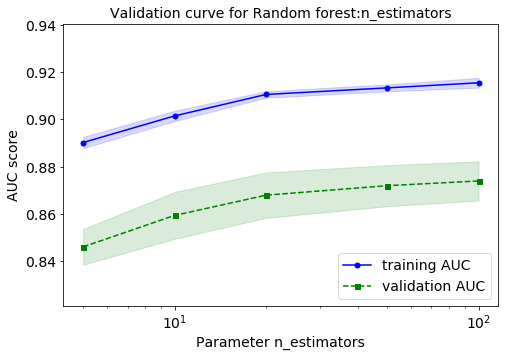

In [113]:
validation_curve_plt(train_mean_rf_est, 
                     train_std_rf_est, 
                     test_mean_rf_est, 
                     test_std_rf_est, 
                     n_estimators, 
                     'n_estimators', 
                     'Random forest')

# Hyperparameter tuning using grid search (random forest).

In [114]:
max_depth_optimized = [2, 4, 6]
n_estimators_optimized = [7, 9, 11, 13, 15, 20, 25, 30, 35]

param_grid = [{'n_estimators': n_estimators_optimized, 'max_depth': max_depth_optimized}]

gs_rf = GridSearchCV(estimator=rand_forest, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs_rf = gs_rf.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs_rf.best_score_))
print('Best parameters: ' + str(gs_rf.best_params_))

Best AUC score on training data: 0.798412216115
Best parameters: {'max_depth': 6, 'n_estimators': 35}


In [115]:
best_rand_forest = gs_rf.best_estimator_
best_rand_forest.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, y_score = best_rand_forest.predict_proba(X_test)[:,1]))

AUC score on test data: 0.770


# Stratified K-fold cross-validation (random forest).

In [116]:
scores_rf = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_rand_forest.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_rand_forest.predict_proba(X_train.values[test_fold])[:,1])
    scores_rf.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\n CV AUC score: %.3f +/- %.3f' % (np.mean(scores_rf), np.std(scores_rf)))

Fold: 1, Class dist.: [13084 13084], Train AUC score: 0.782
Fold: 2, Class dist.: [13084 13084], Train AUC score: 0.800
Fold: 3, Class dist.: [13084 13084], Train AUC score: 0.811
Fold: 4, Class dist.: [13084 13084], Train AUC score: 0.791
Fold: 5, Class dist.: [13084 13084], Train AUC score: 0.803

 CV AUC score: 0.797 +/- 0.010


# Confusion matrix (optimized random forest)

In [117]:
y_pred_rf = best_rand_forest.predict(X_test)
confmat_rf = confusion_matrix(y_true=y_test, y_pred=y_pred_rf, labels = [1,0])
print(confmat_rf)

[[1278  713]
 [1673 5336]]


# Classification report for test data (random forest).

In [118]:
print('AUC score on test data:', roc_auc_score(y_true = y_test, 
                                                    y_score = best_rand_forest.predict_proba(X_test)[:,1]))

AUC score on test data: 0.7706344623


In [119]:
print(classification_report(y_test, y_pred_rf, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.88      0.76      0.82      7009
    defaulted       0.43      0.64      0.52      1991

     accuracy                           0.73      9000
    macro avg       0.66      0.70      0.67      9000
 weighted avg       0.78      0.73      0.75      9000



# ROC and Precision - Recall curves (random forest).

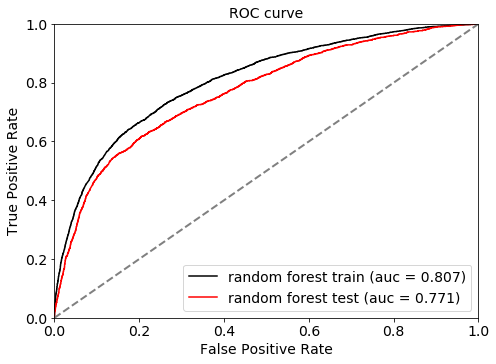

In [120]:
y_pred_rf_train = best_rand_forest.predict_proba(X_train)[:, 1]
y_pred_rf_test = best_rand_forest.predict_proba(X_test)[:, 1]

ROC_plt(y_pred_rf_train, y_pred_rf_test, 'random forest')

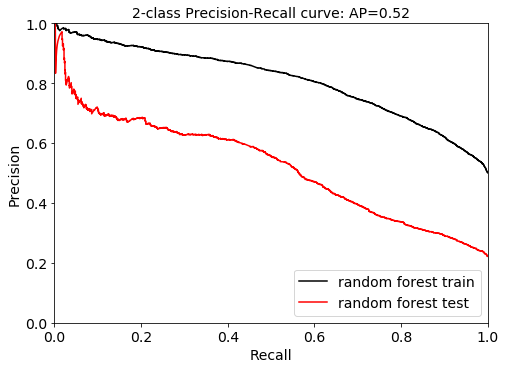

In [121]:
precision_recall_curve_plt(y_pred_rf_train, y_pred_rf_test, 'random forest')

# Feature importances using random forest.

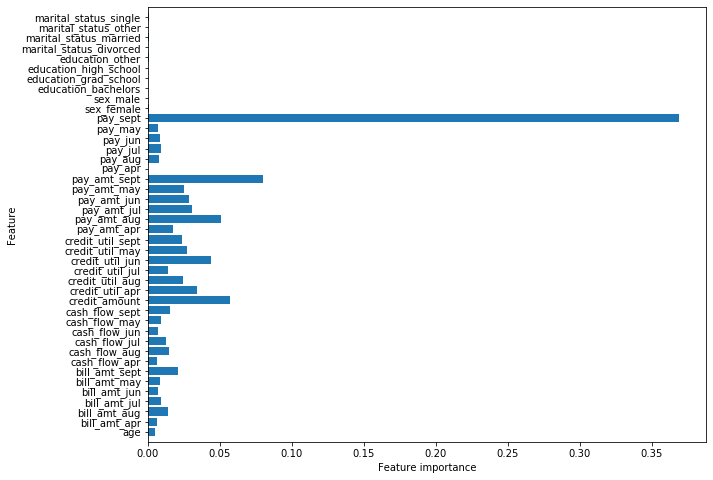

In [122]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    _ = plt.figure(figsize=(10,8))
    _ = plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    _ = plt.yticks(np.arange(n_features), X_train.columns)
    _ = plt.xlabel("Feature importance")
    _ = plt.ylabel("Feature")
    _ = plt.ylim(-1, n_features)
    return plt

plot_feature_importances(best_rand_forest).show()

# SVM

In [37]:
from sklearn.svm import SVC

svm = SVC(probability = True)

# Fit the model on the trainng data.
svm.fit(X_train, y_train)

y_pred_svm_train = svm.predict(X_train)
y_pred_svm_test = svm.predict(X_test)

print('Training accuracy (default SVM):', accuracy_score(y_true = y_train, y_pred = y_pred_svm_train))
print('Test accuracy (default SVM):', accuracy_score(y_true = y_test, y_pred = y_pred_svm_test))

print('AUC score for the training data (default SVM):', 
      roc_auc_score(y_true = y_train, y_score = svm.predict_proba(X_train)[:,1]))
print('AUC score for the test data (default SVM):', 
      roc_auc_score(y_true = y_test, y_score = svm.predict_proba(X_test)[:,1]))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training accuracy (default SVM): 0.745735249159
Test accuracy (default SVM): 0.745555555556
AUC score for the training data (default SVM): 0.825386941243
AUC score for the test data (default SVM): 0.756680350491


In [38]:
C_range = [0.5, 1, 5, 10, 50, 100]

train_mean_svm_C, train_std_svm_C, test_mean_svm_C, test_std_svm_C = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            SVC(gamma = 'scale', probability = True), 
                            C_range, 
                            'C')

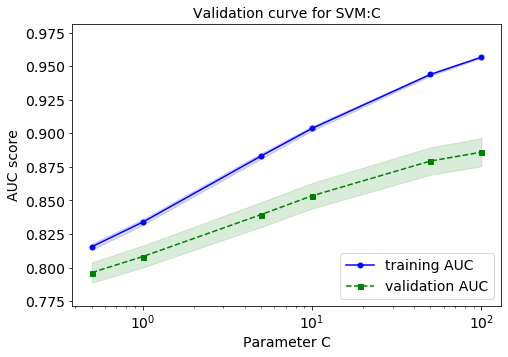

In [39]:
validation_curve_plt(train_mean_svm_C, 
                     train_std_svm_C, 
                     test_mean_svm_C, 
                     test_std_svm_C, 
                     C_range, 
                     'C', 
                     'SVM')

In [40]:
gamma_range = [0.01, 0.033, 0.05, 0.25]

train_mean_svm_gamma, train_std_svm_gamma, test_mean_svm_gamma, test_std_svm_gamma = \
    validation_curve_output(X_train.values, 
                            y_train, 
                            svm, 
                            gamma_range, 
                            'gamma')

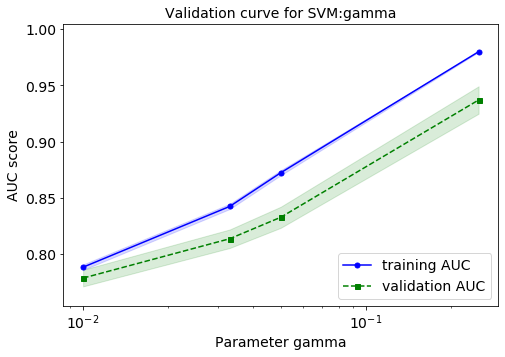

In [41]:
validation_curve_plt(train_mean_svm_gamma, 
                     train_std_svm_gamma, 
                     test_mean_svm_gamma, 
                     test_std_svm_gamma, 
                     gamma_range, 
                     'gamma', 
                     'SVM')

# Hyperparameter tuning using grid search (SVM).

In [42]:
C_range_optimized = [0.1, 0.5, 1]
gamma_range_optimized = [0.01, 0.02, 0.033]

param_grid = [{'C': C_range_optimized, 'gamma': gamma_range_optimized}]

gs_svm = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=5,
                  n_jobs=-1)

gs_svm = gs_svm.fit(X_train, y_train)
print('Best AUC score on training data: ' + str(gs_svm.best_score_))
print('Best parameters: ' + str(gs_svm.best_params_))

Best AUC score on training data: 0.813812048686
Best parameters: {'C': 1, 'gamma': 0.033}


In [43]:
best_svm = gs_svm.best_estimator_
best_svm.fit(X_train, y_train)
print('AUC score on test data: %.3f' 
      %roc_auc_score(y_true = y_test, y_score = best_svm.predict_proba(X_test)[:,1]))

AUC score on test data: 0.756


# Stratified K-fold cross-validation (SVM).

In [44]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores_svm = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    best_svm.fit(X_train.values[train_fold], y_train[train_fold])
    score = roc_auc_score(y_true = y_train[test_fold], 
                          y_score = best_svm.predict_proba(X_train.values[test_fold])[:,1])
    scores_svm.append(score)
    print('Fold: %s, Class dist.: %s, Train AUC score (optimized SVM): %.3f' 
          %(k+1, np.bincount(y_train[train_fold]), score))

print('\n CV train AUC score (optimized SVM): %.3f +/- %.3f' % (np.mean(scores_svm), np.std(scores_svm)))

Fold: 1, Class dist.: [13084 13084], Train AUC score (optimized SVM): 0.798
Fold: 2, Class dist.: [13084 13084], Train AUC score (optimized SVM): 0.817
Fold: 3, Class dist.: [13084 13084], Train AUC score (optimized SVM): 0.821
Fold: 4, Class dist.: [13084 13084], Train AUC score (optimized SVM): 0.808
Fold: 5, Class dist.: [13084 13084], Train AUC score (optimized SVM): 0.813

 CV train AUC score (optimized SVM): 0.811 +/- 0.008


# Confusion matrix (optimized SVM)

In [45]:
y_pred_best_svm = best_svm.predict(X_test)
confmat_svm = confusion_matrix(y_true=y_test, y_pred=y_pred_best_svm, labels = [1,0])
print(confmat_svm)

[[1253  738]
 [1584 5425]]


# Classification report (optimized SVM).

In [46]:
print('AUC score on test data:', roc_auc_score(y_true = y_test, 
                                                    y_score = best_svm.predict_proba(X_test)[:,1]))

AUC score on test data: 0.754956442241


In [47]:
print(classification_report(y_test, y_pred_best_svm, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.88      0.77      0.82      7009
    defaulted       0.44      0.63      0.52      1991

     accuracy                           0.74      9000
    macro avg       0.66      0.70      0.67      9000
 weighted avg       0.78      0.74      0.76      9000



# ROC and Precision - Recall curves (SVM).

In [52]:
y_pred_svm_train = best_svm.predict_proba(X_train)[:, 1]
y_pred_svm_test = best_svm.predict_proba(X_test)[:, 1]

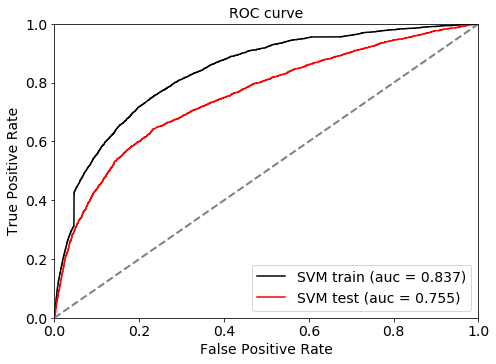

In [53]:
ROC_plt(y_pred_svm_train, y_pred_svm_test, 'SVM')

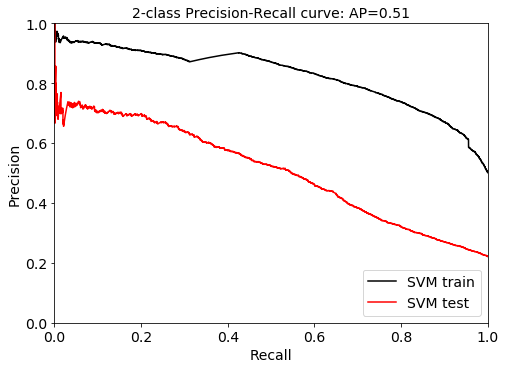

In [56]:
precision_recall_curve_plt(y_pred_svm_train, y_pred_svm_test, 'SVM')

# Voting classifier based on optimized logistic regression, random forest and SVM.

In [127]:
from sklearn.ensemble import VotingClassifier
clf1 = best_clf
clf2 = best_rand_forest
clf3 = best_svm

ensemble = VotingClassifier(estimators=[('logred', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')

# Fit the model on the trainng data.
ensemble.fit(X_train, y_train)

y_pred_ensemble_train = ensemble.predict(X_train)
y_pred_ensemble_test = ensemble.predict(X_test)

print('Training accuracy (ensemble):', 
      accuracy_score(y_true = y_train, y_pred = y_pred_ensemble_train))
print('Test accuracy (ensemble):', 
      accuracy_score(y_true = y_test, y_pred = y_pred_ensemble_test))

y_proba_ensemble_train = ensemble.predict_proba(X_train)[:, 1]
y_proba_ensemble_test = ensemble.predict_proba(X_test)[:, 1]

print('AUC score for the training data (ensemble):', 
      roc_auc_score(y_true = y_train, y_score = y_proba_ensemble_train))
print('AUC score for the test data (ensemble):', 
      roc_auc_score(y_true = y_test, y_score = y_proba_ensemble_test))

Training accuracy (ensemble): 0.739773769489
Test accuracy (ensemble): 0.743888888889
AUC score for the training data (ensemble): 0.823096361763
AUC score for the test data (ensemble): 0.765734075561


# Classification report (ensemble).

In [128]:
print(classification_report(y_test, y_pred_ensemble_test, target_names=['not defaulted', 'defaulted']))

               precision    recall  f1-score   support

not defaulted       0.88      0.78      0.83      7009
    defaulted       0.44      0.63      0.52      1991

     accuracy                           0.74      9000
    macro avg       0.66      0.70      0.67      9000
 weighted avg       0.78      0.74      0.76      9000



# ROC and Precision - Recall curves (SVM).

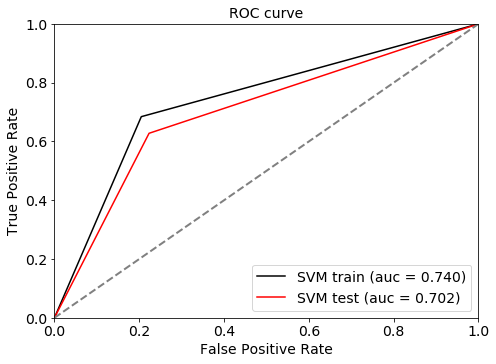

In [129]:
ROC_plt(y_pred_ensemble_train, y_pred_ensemble_test, 'SVM')

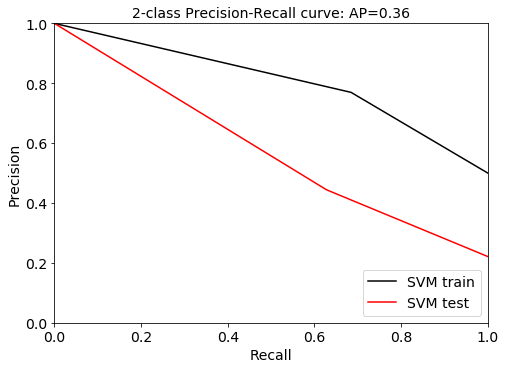

In [130]:
precision_recall_curve_plt(y_pred_ensemble_train, y_pred_ensemble_test, 'SVM')

# Feature importance using logistic regression and statsmodels.

In [132]:
import statsmodels.api as sm

# define the model
logit = sm.Logit(y_train, X_train)

# fit the model
result = logit.fit()

print(result.summary())

         Current function value: 0.597689
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                32710
Model:                          Logit   Df Residuals:                    32670
Method:                           MLE   Df Model:                           39
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:                  0.1377
Time:                        11:04:43   Log-Likelihood:                -19550.
converged:                      False   LL-Null:                       -22673.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
age                         0.0437      0.014      3.031      0.002       0.015       0.072
bill_amt_apr              

//anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
//anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
//anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
//anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


** Removing columns for which matrix rank is not equal to the number of columns. Where rank is the maximum number of linearly independent column vectors in the matrix. **

In [136]:
from numpy.linalg import matrix_rank

X_train_reduced = X_train

i = 1
while(i <= X_train_reduced.shape[1]):
    if matrix_rank(X_train_reduced.iloc[:,:i])!=i:
        print("Dropping due to multicollinearity",X_train_reduced.columns[i-1]) 
        X_train_reduced.drop(X_train_reduced.columns[i-1], axis=1,inplace=True)
    else:
        i = i+1

** All columns are linearly indepenedent. **

In [138]:
len(X_train_reduced.columns)

40

** Fitting the model to just three variables bill_amt_sept, pay_amt_sept, pay_sept and get pseudo R squared slightly lower than in the model with all variables. **

In [139]:
X_train_reduced['default'] = y_train

In [146]:
from patsy import dmatrices
y_reduced, X_reduced = dmatrices('default ~ bill_amt_sept + pay_amt_sept + pay_sept', 
                                 data=X_train_reduced, return_type='dataframe')

In [147]:
# define the model with less features
logit_reduced = sm.Logit(y_reduced, X_reduced)

# fit the model
result_reduced = logit_reduced.fit()

print(result_reduced.summary())

Optimization terminated successfully.
         Current function value: 0.612123
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                32710
Model:                          Logit   Df Residuals:                    32706
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:                  0.1169
Time:                        14:05:56   Log-Likelihood:                -20023.
converged:                       True   LL-Null:                       -22673.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0228      0.012      1.889      0.059      -0.001       0.046
bill_amt_sept    -0.